<a href="https://colab.research.google.com/github/UrviSoni/pytorch_deeplearning/blob/master/flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Run this cell to download the Udacity flower set
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip


In [6]:
!unzip -qq flower_data.zip


replace flower_data/valid/61/image_06296.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace flower_data/valid/61/image_06293.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace flower_data/valid/61/image_06292.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace flower_data/valid/61/image_06261.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace flower_data/valid/61/image_06259.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace flower_data/valid/61/image_06273.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
# Import resources
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL

from PIL import Image
from collections import OrderedDict


import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

import os

In [2]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Bummer!  Training on CPU ...')
else:
    print('You are good to go!  Training on GPU ...')


You are good to go!  Training on GPU ...


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'


In [0]:
# Define your transforms for the training and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

# Using the image datasets and the trainforms, define the dataloaders
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}

class_names = image_datasets['train'].classes


In [0]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes


In [10]:
print(dataset_sizes)
print(device)


{'train': 6552, 'valid': 818}
cuda:0


In [0]:
# Label mapping
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)


In [12]:
# Run this to test the data loader
images, labels = next(iter(dataloaders['train']))
images.size()


torch.Size([64, 3, 224, 224])

In [13]:
# # Run this to test your data loader
images, labels = next(iter(dataloaders['train']))
rand_idx = np.random.randint(len(images))
# print(rand_idx)
print("label: {}, class: {}, name: {}".format(labels[rand_idx].item(),
                                               class_names[labels[rand_idx].item()],
                                               cat_to_name[class_names[labels[rand_idx].item()]]))


label: 77, class: 77, name: passion flower


In [14]:
model_name = 'densenet' #vgg
if model_name == 'densenet':
    model = models.densenet161(pretrained=True)
    num_in_features = 2208
    print(model)
elif model_name == 'vgg':
    model = models.vgg19(pretrained=True)
    num_in_features = 25088
    print(model.classifier)
else:
    print("Unknown model, please choose 'densenet' or 'vgg'")


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:01<00:00, 108220824.61it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [0]:
# Create classifier
for param in model.parameters():
    param.requires_grad = False

def build_classifier(num_in_features, hidden_layers, num_out_features):
   
    classifier = nn.Sequential()
    if hidden_layers == None:
        classifier.add_module('fc0', nn.Linear(num_in_features, 102))
    else:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(.6))
        classifier.add_module('relu1', nn.ReLU())
        classifier.add_module('drop1', nn.Dropout(.5))
        for i, (h1, h2) in enumerate(layer_sizes):
            classifier.add_module('fc'+str(i+1), nn.Linear(h1, h2))
            classifier.add_module('relu'+str(i+1), nn.ReLU())
            classifier.add_module('drop'+str(i+1), nn.Dropout(.5))
        classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))
        
    return classifier


In [16]:
hidden_layers = None#[4096, 1024, 256][512, 256, 128]

classifier = build_classifier(num_in_features, hidden_layers, 102)
print(classifier)

 # Only train the classifier parameters, feature parameters are frozen
if model_name == 'densenet':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(model.parameters()) # Adadelta #weight optim.Adam(model.parameters(), lr=0.001, momentum=0.9)
    #optimizer_conv = optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.001, momentum=0.9)
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4)
elif model_name == 'vgg':
    model.classifier = classifier
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
    sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
else:
    pass


Sequential(
  (fc0): Linear(in_features=2208, out_features=102, bias=True)
)


In [0]:
# Adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, sched, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #sched.step()
                        loss.backward()
                        
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    
    return model


In [18]:
epochs = 30
model.to(device)
model = train_model(model, criterion, optimizer, sched, epochs)


Epoch 1/30
----------
train Loss: 2.4341 Acc: 0.4889
valid Loss: 0.9610 Acc: 0.8203

Epoch 2/30
----------
train Loss: 0.8120 Acc: 0.8404
valid Loss: 0.4608 Acc: 0.8985

Epoch 3/30
----------
train Loss: 0.5263 Acc: 0.8913
valid Loss: 0.3345 Acc: 0.9315

Epoch 4/30
----------
train Loss: 0.4128 Acc: 0.9101
valid Loss: 0.2470 Acc: 0.9450

Epoch 5/30
----------
train Loss: 0.3448 Acc: 0.9223
valid Loss: 0.2612 Acc: 0.9279

Epoch 6/30
----------
train Loss: 0.3132 Acc: 0.9263
valid Loss: 0.2032 Acc: 0.9523

Epoch 7/30
----------
train Loss: 0.2693 Acc: 0.9377
valid Loss: 0.1939 Acc: 0.9499

Epoch 8/30
----------
train Loss: 0.2490 Acc: 0.9418
valid Loss: 0.1786 Acc: 0.9560

Epoch 9/30
----------
train Loss: 0.2553 Acc: 0.9412
valid Loss: 0.1611 Acc: 0.9658

Epoch 10/30
----------
train Loss: 0.2284 Acc: 0.9426
valid Loss: 0.1477 Acc: 0.9633

Epoch 11/30
----------
train Loss: 0.2176 Acc: 0.9501
valid Loss: 0.1729 Acc: 0.9584

Epoch 12/30
----------
train Loss: 0.2158 Acc: 0.9480
valid Los

In [19]:
# Evaluation

model.eval()

accuracy = 0

for inputs, labels in dataloaders['valid']:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    
    # Class with the highest probability is our predicted class
    equality = (labels.data == outputs.max(1)[1])

    # Accuracy is number of correct predictions divided by all predictions
    accuracy += equality.type_as(torch.FloatTensor()).mean()
    
print("Test accuracy: {:.3f}".format(accuracy/len(dataloaders['valid'])))


Test accuracy: 0.968


In [0]:
# Saving the checkpoint
model.class_to_idx = image_datasets['train'].class_to_idx

In [0]:
checkpoint = {'input_size': 2208,
              'output_size': 102,
              'epochs': epochs,
              'batch_size': 64,
              'model': models.densenet161(pretrained=True),
              'classifier': classifier,
              'scheduler': sched,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx
             }
   
torch.save(checkpoint, 'checkpoint_ic_d161.pth')


In [25]:
# Loading the checkpoint
ckpt = torch.load('checkpoint_ic_d161.pth')
ckpt.keys()

dict_keys(['input_size', 'output_size', 'epochs', 'batch_size', 'model', 'classifier', 'scheduler', 'optimizer', 'state_dict', 'class_to_idx'])

In [0]:
# Load a checkpoint and rebuild the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer = checkpoint['optimizer']
    epochs = checkpoint['epochs']
    
    for param in model.parameters():
        param.requires_grad = False
        
    return model, checkpoint['class_to_idx']


In [27]:
model, class_to_idx = load_checkpoint('checkpoint_ic_d161.pth')
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [0]:
idx_to_class = { v : k for k,v in class_to_idx.items()}


In [0]:
image_path = 'flower_data/valid/102/image_08006.jpg'
img = Image.open(image_path)


In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Process a PIL image for use in a PyTorch model
    # tensor.numpy().transpose(1, 2, 0)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image


In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


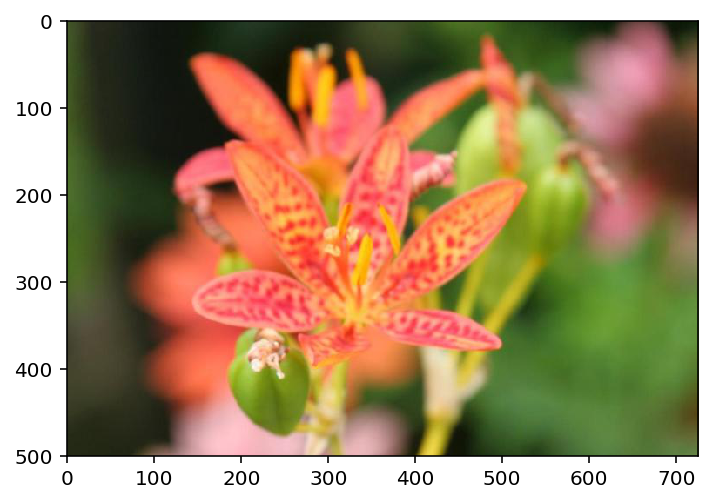

In [32]:
with Image.open('flower_data/valid/102/image_08006.jpg') as image:
    plt.imshow(image)


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [0]:
model.class_to_idx = image_datasets['train'].class_to_idx


In [0]:
def predict2(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    img = Image.open(image_path)
    img = process_image(img)
    
    # Convert 2D image to 1D vector
    img = np.expand_dims(img, 0)
    
    
    img = torch.from_numpy(img)
    
    model.eval()
    inputs = Variable(img).to(device)
    logits = model.forward(inputs)
    
    ps = F.softmax(logits,dim=1)
    topk = ps.cpu().topk(topk)
    
    return (e.data.numpy().squeeze().tolist() for e in topk)


In [38]:
img_path = 'flower_data/valid/19/image_06158.jpg'
probs, classes = predict2(img_path, model.to(device))
print(probs)
print(classes)
flower_names = [cat_to_name[class_names[e]] for e in classes]
print(flower_names)


[0.9999427795410156, 1.774113297869917e-05, 1.3908185792388394e-05, 1.3490357559930999e-05, 6.337582362903049e-06]
[13, 41, 83, 100, 68]
['balloon flower', 'poinsettia', 'clematis', 'mexican petunia', 'windflower']


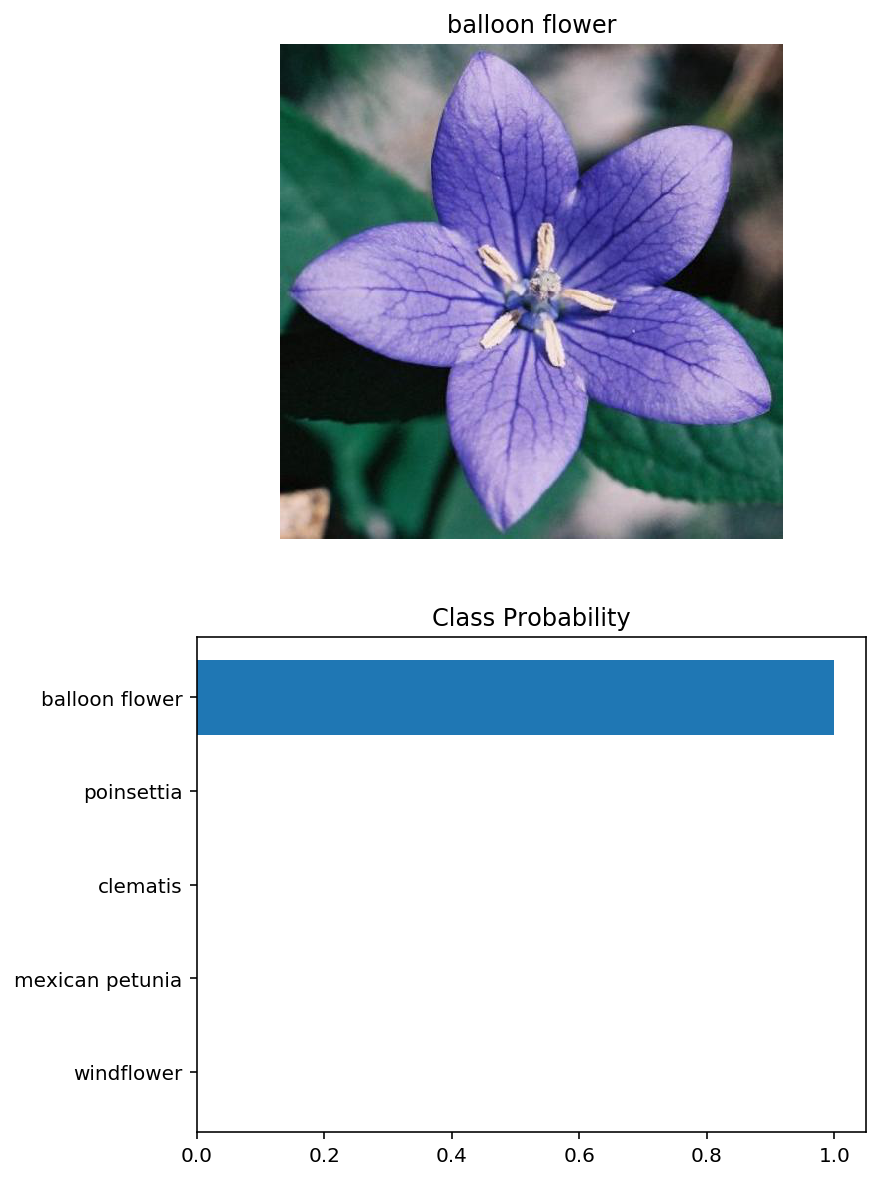

In [39]:
def view_classify(img_path, prob, classes, mapping):
    ''' Function for viewing an image and it's predicted classes.
    '''
    image = Image.open(img_path)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapping[img_path.split('/')[-2]]
    ax1.set_title(flower_name)
    ax1.imshow(image)
    ax1.axis('off')
    
    y_pos = np.arange(len(prob))
    ax2.barh(y_pos, prob, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(flower_names)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Class Probability')

view_classify(img_path, probs, classes, cat_to_name)
